In [1]:
from netCDF4 import Dataset

import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
with Dataset(os.path.join('data', 'wind_psl', 'pr.std.nc4'), "r", format="NETCDF4") as file:
    std = file['pr'][0].item()

 Commonly used threshold to define dry_days is 0.1 mm/day


In [3]:
threshold = 0.1

## Functions

### Units:
The output of edvae is precipitation_flux $\left[\frac{\text{kg}}{\text{m}^2 \text{s}}\right]$ divided by its standard deviation over all years and grid points.

In [4]:
def normalized_flux_to_mm_per_d(pr_norm_flux, std):
    return pr_norm_flux * std * 60 * 60 * 24
def mm_per_d_to_normalized_flux(mm_per_day, std):
    return mm_per_day / std / 60 / 60 / 24

In [5]:
def percentile_error(observed, downscaled, percentile):
    error = np.zeros(observed.shape[1:])
    for i in range(observed.shape[1]):
        for j in range(observed.shape[2]):
            wet_days = observed[:,i,j][observed[:,i,j] > threshold]
            downscaled_wet_days = downscaled[:,i,j][downscaled[:,i,j] > threshold]
            error[i,j] = np.percentile(downscaled_wet_days,percentile) - np.percentile(wet_days,percentile)
    return error


In [6]:
def mean_abs_percentile_error(observed, downscaled, percentile):
    return np.mean(np.abs(percentile_error(observed, downscaled, percentile)))

In [7]:
def read_data(path, margin):
    with Dataset(path, "r", format="NETCDF4") as file:
        pr = file['pr'][:,margin:-margin,margin:-margin]
        pr_recon = file['downscaled_pr_0'][:,margin:-margin,margin:-margin]
        pr_interpol = file['bilinear_downscaled_pr'][:,margin:-margin,margin:-margin]
        t = len(file['time'])
        # convert to mm/d
        pr = normalized_flux_to_mm_per_d(pr, std)
        pr_recon = normalized_flux_to_mm_per_d(pr_recon, std)
        pr_interpol = normalized_flux_to_mm_per_d(pr_interpol, std)
        
        return pr, pr_recon, pr_interpol, t

In [8]:
def print_percentile_errors(name, load_epoch, percentiles):
    result_dir =  os.path.join('results', name, 'val_{}'.format(load_epoch), '')
    total_recon_errors = []
    total_interpol_errors = []
    for filename in os.listdir(result_dir):
        if filename.startswith('val.'):
            pr, pr_recon, pr_interpol, t = read_data(path=os.path.join(result_dir, filename), margin=8)
            local_recon_errors = []
            local_interpol_errors = []
            print(filename)
            for percentile in percentiles:
                recon_error = mean_abs_percentile_error(pr, pr_recon, percentile)
                interpol_error = mean_abs_percentile_error(pr, pr_interpol, percentile)
                print("{}th percentile of edvae = {} \t bilinear interpolation = {}".
                      format(percentile, recon_error, interpol_error)) 
                local_recon_errors.append(recon_error)
                local_interpol_errors.append(interpol_error)
            total_recon_errors.append(local_recon_errors)
            total_interpol_errors.append(local_interpol_errors)
    average_recon = np.mean(total_recon_errors, 1)
    average_interpol = np.mean(total_interpol_errors, 1)
    print('--------------------------------------------------------------------------------')
    for i in range(len(percentiles)):
        print('average errors for {}th percentile of edvae = {}, bilinear interpolation = {}'.
              format(percentiles[i], average_recon[i], average_interpol[i]))
    return total_recon_errors, total_interpol_errors

In [74]:
def plot_percentile_errors(paths, area, percentiles, absolute=False):
    fig, axes = plt.subplots(len(percentiles), len(paths)+1, sharex=True, sharey=True, figsize = (20, 20))
    # plot pr and interpol_pr, set v_min, v_max to the pr max and min value
    pr, _, pr_interpol, _ = read_data(path=os.path.join(paths[0], area), margin=8)
    vmax = []
    for i in range(len(percentiles)):
        interpol_error = percentile_error(pr, pr_interpol, percentiles[i])
        
        vmax.append(np.abs(interpol_error).max())
        if absolute:
            axes[i,-1].imshow(np.abs(interpol_error), cmap=plt.get_cmap('bwr'),
                              vmin=-vmax[i], vmax=vmax[i])
        else:
            axes[i,-1].imshow(interpol_error, cmap=plt.get_cmap('bwr'),
                              vmin=-vmax[i], vmax=vmax[i])
        axes[i,-1].set_title('bilinear interpolated')
        axes[i,-1].set_ylabel('{}th percentile'.format(percentiles[i]), rotation=90, size='large')
    for j in range(len(paths)):
        _, pr_recon, _, _ = read_data(path=os.path.join(paths[j], area), margin=8)
        for i in range(len(percentiles)):
            if absolute:
                axes[i,j].imshow(np.abs(percentile_error(pr, pr_recon, percentiles[i])), cmap=plt.get_cmap('bwr'),
                                vmin=-vmax[i], vmax=vmax[i])
            else:
                axes[i,j].imshow(percentile_error(pr, pr_recon, percentiles[i]), cmap=plt.get_cmap('bwr'),
                                vmin=-vmax[i], vmax=vmax[i])
            axes[i,j].set_title(paths[j])
            axes[i,j].set_ylabel('{}th percentile'.format(percentiles[i]), rotation=90, size='large')
    fig.tight_layout()
    plt.show()
    
            

In [79]:
def plot_percentiles(paths, area, percentiles):
    fig, axes = plt.subplots(len(percentiles), len(paths)+2, sharex=True, sharey=True, figsize = (20, 20))
    # plot pr and interpol_pr, set v_min, v_max to the pr max and min value
    pr, _, pr_interpol, _ = read_data(path=os.path.join(paths[0], area), margin=8)
    vlims = []
    for i in range(len(percentiles)):
        pr_percentile = np.percentile(pr, percentiles[i], axis=0)
        vmin = pr_percentile.min()
        vmax = pr_percentile.max()
        vlims.append([vmin, vmax])
        
        axes[i,-2].imshow(np.percentile(pr_interpol, percentiles[i], axis=0), cmap=plt.get_cmap('jet'),
                          vmin=vmin, vmax=vmax)
        axes[i,-2].set_title('bilinear interpolated')
        axes[i,-2].set_ylabel('{}th percentile'.format(percentiles[i]), rotation=90, size='large')
        axes[i,-1].imshow(pr_percentile, cmap=plt.get_cmap('jet'), vmin=vmin, vmax=vmax)
        axes[i,-1].set_title('observed')
        axes[i,-1].set_ylabel('{}th percentile'.format(percentiles[i]), rotation=90, size='large')
    for j in range(len(paths)):
        _, pr_recon, _, _ = read_data(path=os.path.join(paths[j], area), margin=8)
        for i in range(len(percentiles)):
            axes[i,j].imshow(np.percentile(pr_recon, percentiles[i], axis=0), cmap=plt.get_cmap('jet'),
                            vmin=vlims[i][0], vmax=vlims[i][1])
            axes[i,j].set_title(paths[j])
            axes[i,j].set_ylabel('{}th percentile'.format(percentiles[i]), rotation=90, size='large')
    fig.tight_layout()
    plt.show()
    
            

## Wet day distribution

In [80]:
print_percentile_errors(name='01_11_mse_48_nz20', load_epoch=0, percentiles=[1,5,50,95,99])

val.lat48_lon120.nc4


KeyboardInterrupt: 

In [81]:
print_percentile_errors(name='01_11_mse_48_nz20', load_epoch=9, percentiles=[1,5,50,95,99])

val.lat48_lon120.nc4
1th percentile of edvae = 0.014888290627714011 	 bilinear interpolation = 0.05842550158777158
5th percentile of edvae = 0.04288226911121456 	 bilinear interpolation = 0.20062427570992444
50th percentile of edvae = 0.14756054428289644 	 bilinear interpolation = 0.18002620231709443
95th percentile of edvae = 0.7618510339409117 	 bilinear interpolation = 3.2889841597527267
99th percentile of edvae = 1.248787360657006 	 bilinear interpolation = 5.492284638378769
val.lat88_lon600.nc4
1th percentile of edvae = 0.02813553958745615 	 bilinear interpolation = 0.027100601129350255
5th percentile of edvae = 0.11535706352078706 	 bilinear interpolation = 0.106048070036195
50th percentile of edvae = 0.9290127160493284 	 bilinear interpolation = 0.9975581476464868
95th percentile of edvae = 2.449624937446786 	 bilinear interpolation = 5.61986677558161
99th percentile of edvae = 5.920375003088262 	 bilinear interpolation = 13.159042976703489
val.lat8_lon80.nc4
1th percentile of e

([[0.014888290627714011,
   0.04288226911121456,
   0.14756054428289644,
   0.7618510339409117,
   1.248787360657006],
  [0.02813553958745615,
   0.11535706352078706,
   0.9290127160493284,
   2.449624937446786,
   5.920375003088262],
  [0.008687404611773673,
   0.03690864482996403,
   0.7039018297291477,
   5.664536802971267,
   10.617431762507186],
  [0.007770909442988341,
   0.03425153147836682,
   0.5036527347692754,
   2.8124573281995238,
   5.805120043074127],
  [0.04964886585607019,
   0.13990484103851486,
   0.2716834199381992,
   0.88553113010712,
   1.806401519104838],
  [0.016120585134558496,
   0.0762758485179802,
   1.384714704065118,
   5.2637853297172095,
   11.256797285405916]],
 [[0.05842550158777158,
   0.20062427570992444,
   0.18002620231709443,
   3.2889841597527267,
   5.492284638378769],
  [0.027100601129350255,
   0.106048070036195,
   0.9975581476464868,
   5.61986677558161,
   13.159042976703489],
  [0.009437171754834706,
   0.04098593533817621,
   0.848424610

In [63]:
print_percentile_errors(name='01_11_gamma_48_nz20_batch_s128', load_epoch=6, percentiles=[1,5,50,95,99])

val.lat48_lon120.nc4
1th percentile of edvae = 0.005929328264974175 	 bilinear interpolation = 0.05842550158777158
5th percentile of edvae = 0.025666507268397254 	 bilinear interpolation = 0.20062427570992444
50th percentile of edvae = 0.22837566392263398 	 bilinear interpolation = 0.18002620231709443
95th percentile of edvae = 0.9554516422096648 	 bilinear interpolation = 3.2889841597527267
99th percentile of edvae = 1.2221887205168631 	 bilinear interpolation = 5.492284638378769
val.lat88_lon600.nc4
1th percentile of edvae = 0.0322057361494808 	 bilinear interpolation = 0.027100601129350255
5th percentile of edvae = 0.13503122053152766 	 bilinear interpolation = 0.106048070036195


KeyboardInterrupt: 

In [81]:
paths = [ 'results/01_11_gamma_48_nz20_batch_s128/val_6/']
percentiles = [50, 99]
area = 'val.lat88_lon560.nc4'

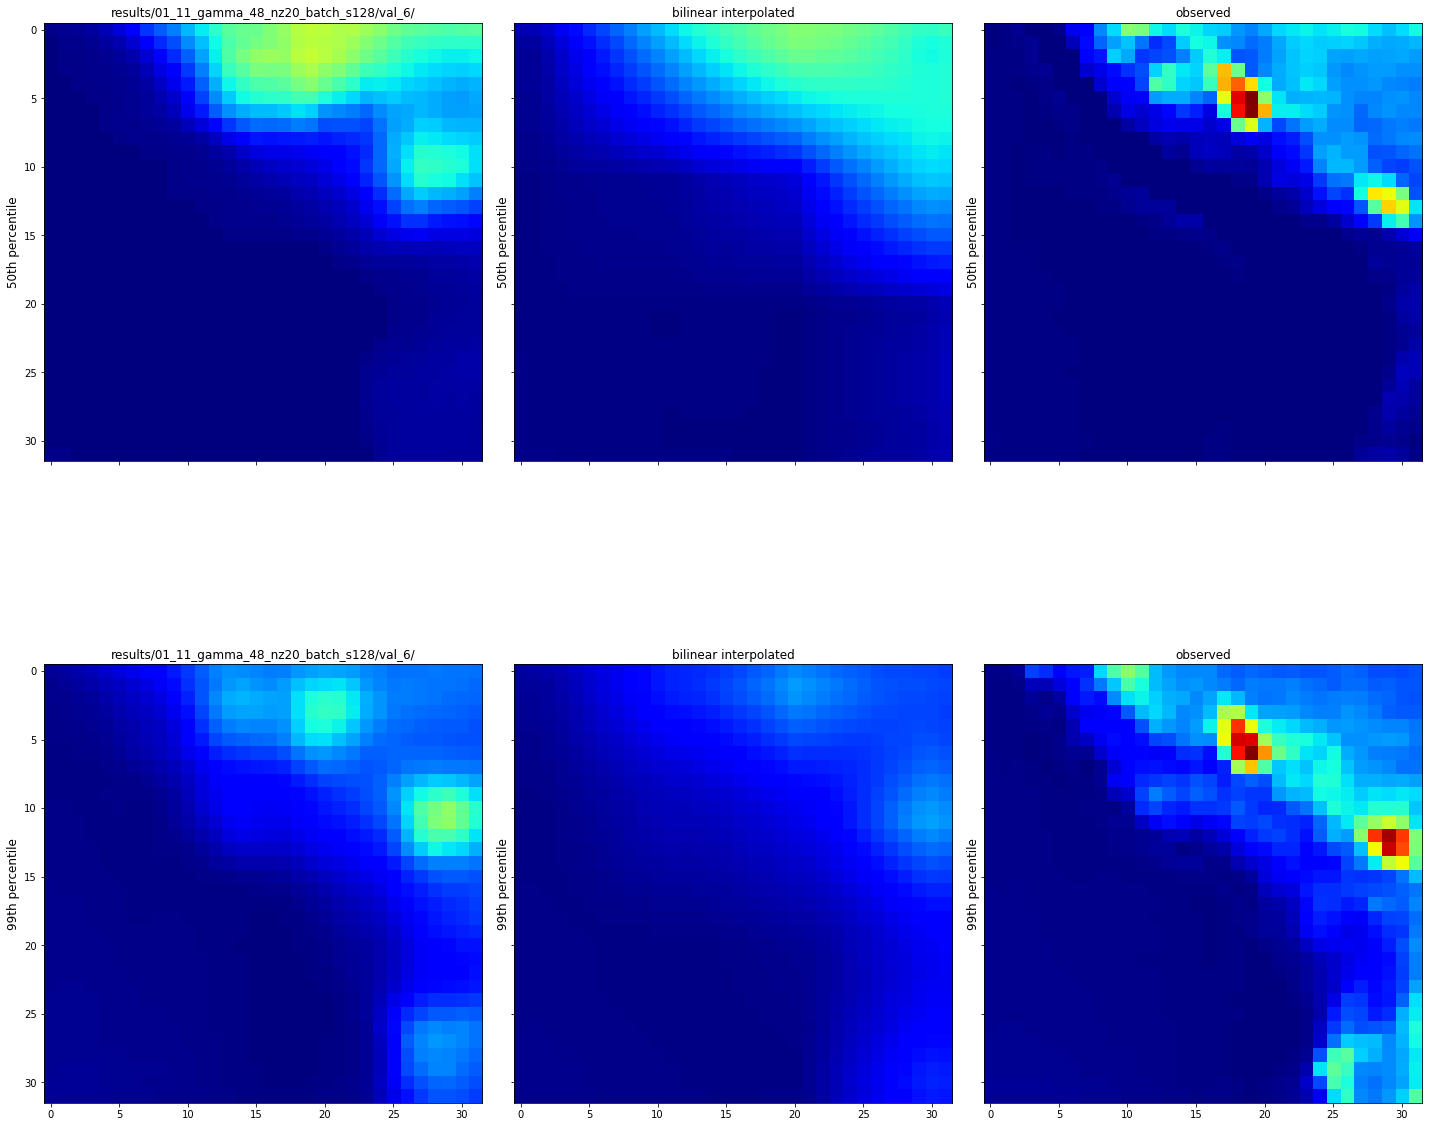

In [82]:
plot_percentiles(paths, area, percentiles)

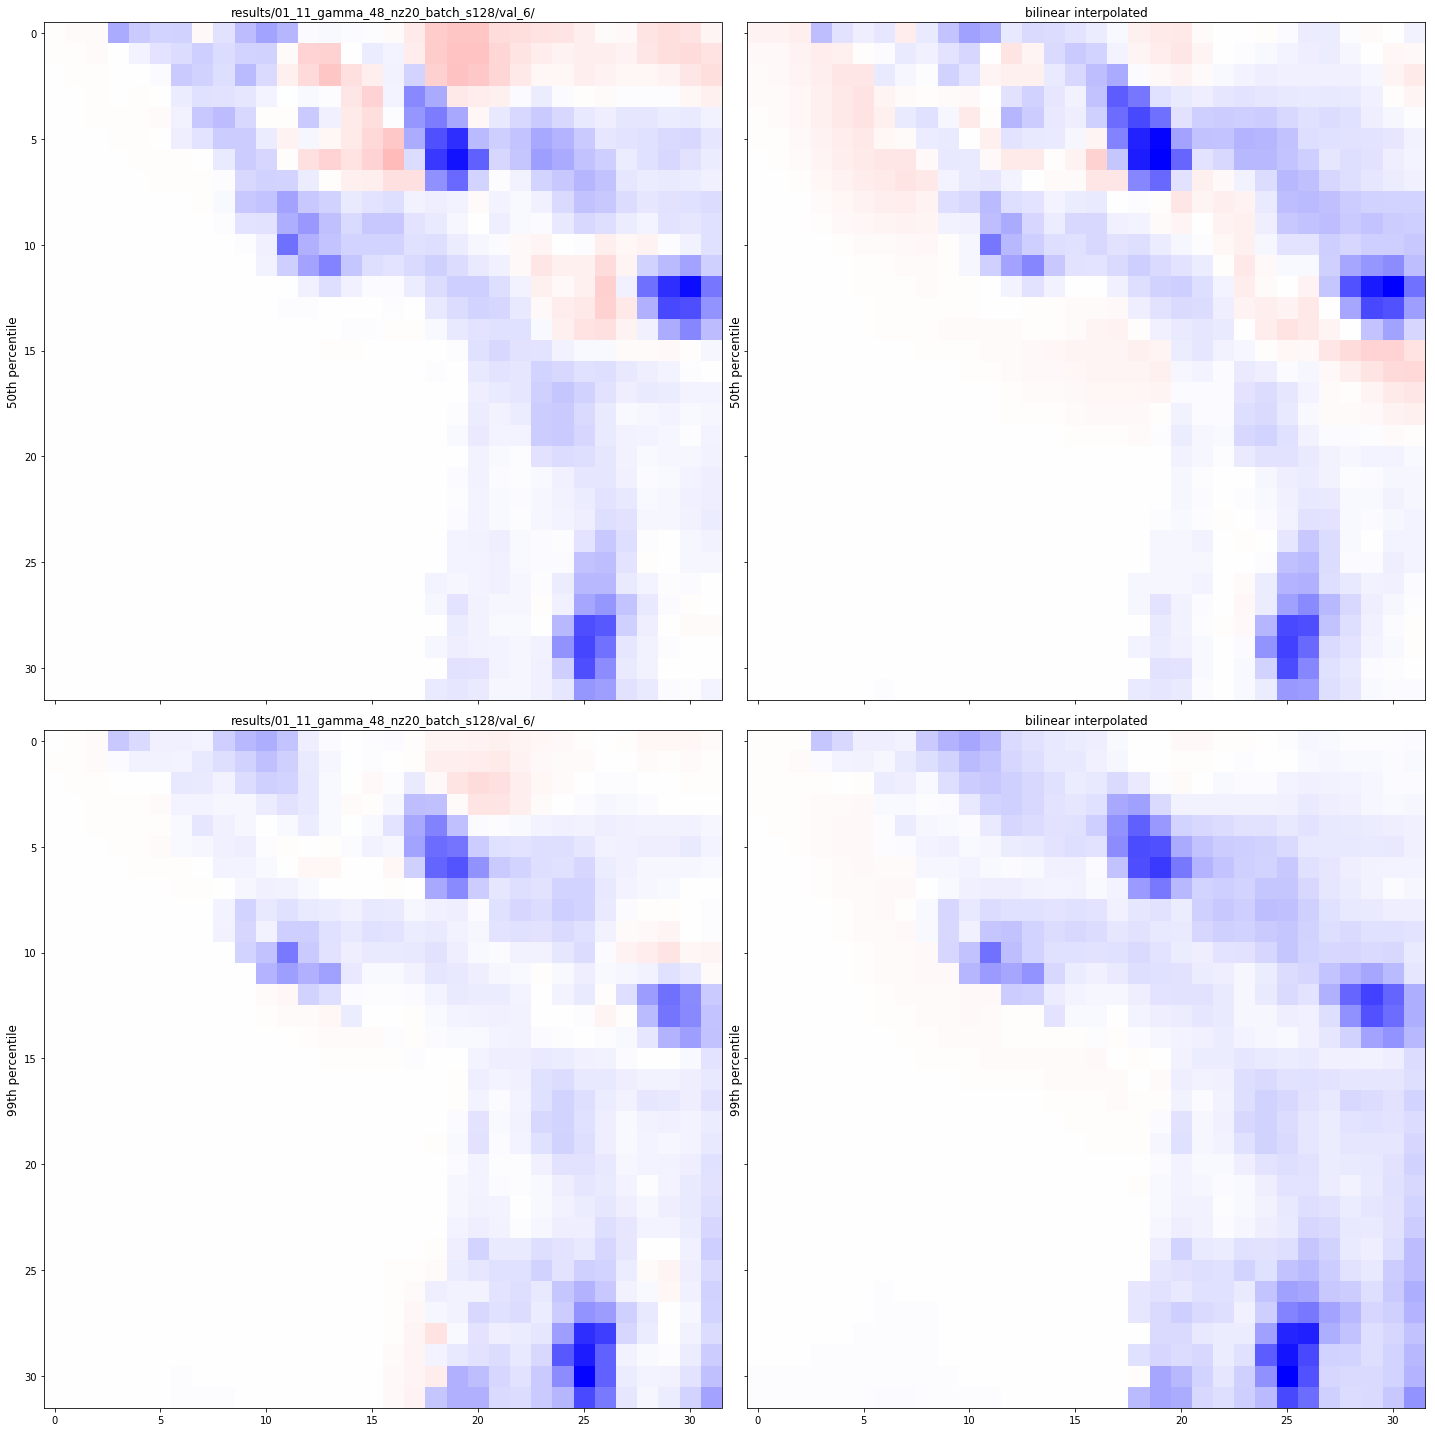

In [83]:
plot_percentile_errors(paths, area, percentiles)

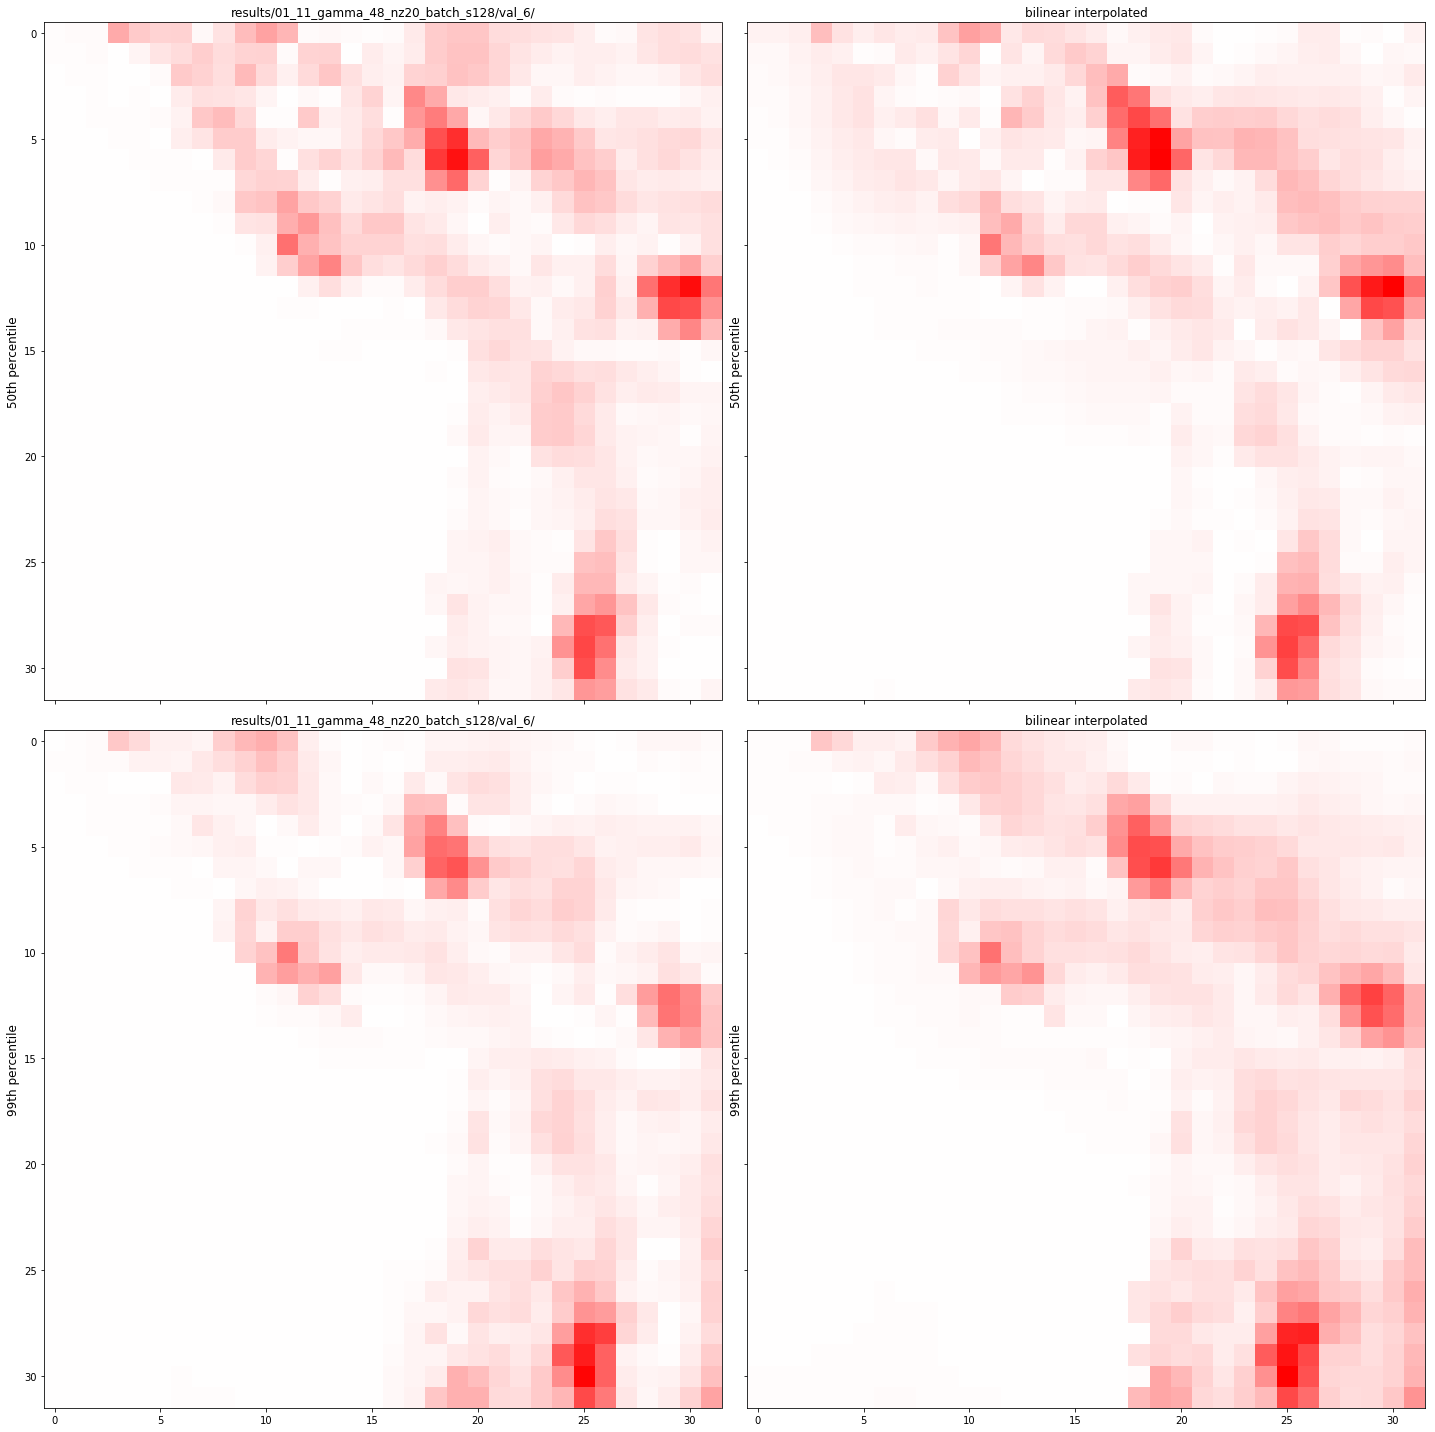

In [84]:
plot_percentile_errors(paths, area, percentiles, absolute=True)

## Dry day fraction

In [41]:
dry_d_frac = np.sum(pr <= 0.1,axis=0)/t
recon_dry_d_frac = np.sum(pr_recon <= 0.1, axis=0)/t
interpol_dry_d_frac = np.sum(pr_interpol <= 0.1, axis=0)/t
error_recon_dry_d_frac = recon_dry_d_frac - dry_d_frac
error_interpol_dry_d_frac = interpol_dry_d_frac - dry_d_frac

NameError: name 'pr' is not defined

NameError: name 'error_recon_dry_d_frac' is not defined

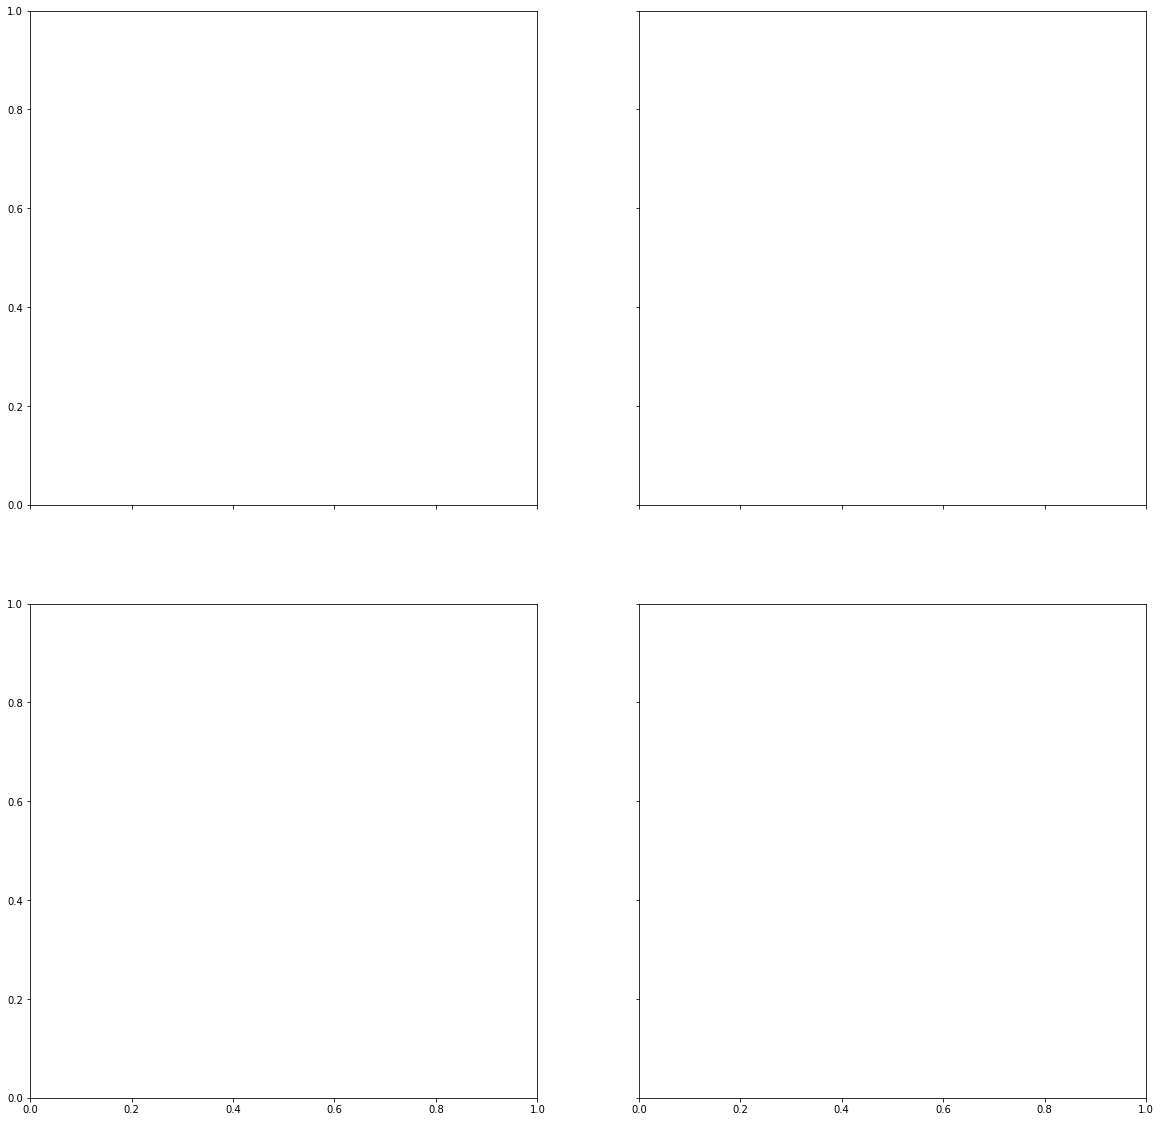

In [42]:
fig, axes = plt.subplots(2, 2, sharex='col', sharey='row', figsize = (20, 20))
v_min = -.5
v_max = .5
axes[0,0].imshow(error_recon_dry_d_frac, cmap=plt.get_cmap('bwr'), vmin=v_min, vmax=v_max)
im = axes[0,1].imshow(error_interpol_dry_d_frac, cmap=plt.get_cmap('bwr'), vmin=v_min, vmax=v_max)
axes[1,0].imshow(np.abs(error_recon_dry_d_frac), cmap=plt.get_cmap('bwr'), vmin=v_min, vmax=v_max)
im = axes[1,1].imshow(np.abs(error_interpol_dry_d_frac), cmap=plt.get_cmap('bwr'), vmin=v_min, vmax=v_max)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [54]:
np.mean(np.abs(error_interpol_dry_d_frac))

0.1796874236105679

In [55]:
np.mean(np.abs(error_recon_dry_d_frac))

0.07951032235118116